# VAE를 통한 목표 소음 저감 성능을 만족하는 통기성 소음 감쇠기 구조 역설계

![overall_flow](picture/overall_flow.png)

VAE를 통한 통기성 소음 감쇠기(Ventilated acoustic resonator) 역설계
- 음향 반응(Acoustic Response) 을 입력하면 다양한 통기성 소음 감쇠기 구조를 생성하는 인공지능 모델
- VAE 구조를 통해 통기성 소음 감쇠기 구조 학습하여 이미지 분포 생성
- VAE 구조의 잠재 공간(Latent space) 과 차원 축소된 음향 반응을 결합하여 감쇠기 구조와 음향 반응을 반영한 새로운 형태의 감쇠기 구조 생성 목표

In [ ]:
from random import sample
from re import T
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, estimate_bandwidth


# 통기성 소음 감쇠기 데이터 불러오기

## 이미지 및 시뮬레이션 결과 데이터 불러오기

구조 파라미터 : 이미지로 저장 시 불러오는 시간 소요 증가. 따라서 구조 파라미터를 불러온 후 이미지로 변환  
시뮬레이션 결과 : 1~1961Hz 를 40Hz 간격으로 총 50개의 Hz에 대한 투과 손실(Transmission loss) 데이터 → 학습을 위해 (dataset 개수, 50, 1)로 reshape

Train dataset : 37,345개  
Test dataset : 16,005개
Total dataset : 53,350개

![data_](picture/data_.png)

In [1]:
parameter_train = np.array(pd.read_csv('data/inverse_design/accept2_parameter_train.csv',header=None))
parameter_test = np.array(pd.read_csv('data/inverse_design/accept2_parameter_test.csv',header=None))
train_TL = np.array(pd.read_csv('data/inverse_design/accept2_TL_train.csv',header=None)).reshape(37345,50,1)
test_TL = np.array(pd.read_csv('data/inverse_design/accept2_TL_test.csv',header=None)).reshape(16005,50,1)

NameError: name 'np' is not defined

## 이미지 파라미터 데이터 → 이미지로 변환

파라미터를 (128×64) 이미지로 변환  
cv2 라이브러리를 통해 직사각형 구조 생성(CV2 : 컴퓨터 비전 라이브러리)

![parameter_image](picture/parameter_image.png)

구조 파라미터 → 이미지 생성을 위한 Class 정의

In [3]:
class generator():
    
    def __init__(self):
        self.width = 64
        self.height= 128

    def geometry(self,ta,d,rd,ra,l):
        self.case = np.zeros((self.height,self.width, 3),dtype = np.float32)
        self.case = cv2.rectangle(self.case,(16,self.height-rd),(55,self.height-1),(255,255,255),-1)
        self.case = cv2.rectangle(self.case,(36-d,self.height-rd-l),(36+d-1,self.height-rd-1),(255,255,255),-1)
        self.case = cv2.rectangle(self.case,(36-ta,self.height-ra),(36+ta-1, self.height-rd-l-1),(255,255,255),-1)
        self.case = cv2.cvtColor(self.case, cv2.COLOR_BGR2GRAY)
        self.case = self.case.reshape( self.case.shape+(1,))
        self.case = self.case/255
        return self.case
generator = generator()

구조 데이터에 대한 Train, Test 데이터 셋을 이미지화

In [4]:

#%%
train_images = []
test_images = []
for i in range(len(parameter_train)):
    train_image1 = np.array(generator.geometry(parameter_train[i,0],parameter_train[i,1],parameter_train[i,2],parameter_train[i,3],
                                               parameter_train[i,4]))
    parameter_num = np.array(np.ones(64)*i).reshape(1,64,1)
    train_images.append(train_image1)
print(np.shape(train_images),'train image 생성 끝')

for i in range(len(parameter_test)):
    test_image1 = np.array(generator.geometry(parameter_test[i,0],parameter_test[i,1],parameter_test[i,2],parameter_test[i,3],
                                              parameter_test[i,4]))
    parameter_num = np.array(np.ones(64)*i).reshape(1,64,1)
    test_images.append(test_image1)
print(np.shape(test_images),'test image 생성 끝')

(37345, 128, 64, 1) train image 생성 끝
(16005, 128, 64, 1) test image 생성 끝


## 데이터 배치 슬라이스

In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_TL)).shuffle(1).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_TL)).shuffle(1).batch(batch_size) 
print('train 수:',len(train_images),'test 수:',len(test_images))

1
train 수: 37345 test 수: 16005


## 데이터 배치 슬라이스

![vae_exp_structure](picture/vae_exp_structure.png)

![vae_explain](picture/vae_explain.png)

![VAE](picture/VAE.png)

## Encoder 구조 생성

VAE 구조에서 Encoder의 신경망 구조
- 통기성 소음 감쇠기 구조 학습을 위한 Convolutional neural network(CNN) 활용 + ResNet
- CNN 이후 'flatten' 을 통해 Deep nerual network(DNN) 구조로 변환
- 출력은 12차원의 잠재 공간(Latent space)를 나타내기 위해 (평균 12개 + 분산 12개) → 총 24개  

![encoder](picture/encoder.png)

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv0_0 = tf.keras.layers.Conv2D(8,(1,1), strides= 1, padding='valid')
        self.conv0_1 = tf.keras.layers.Conv2D(8,(3,3), strides= 1, padding='same')
        self.conv0_2 = tf.keras.layers.Conv2D(16,(1,1), strides= 1, padding='valid')
        self.conv1_0 = tf.keras.layers.Conv2D(16,(1,1), strides= 2, padding='valid')
        self.conv1_1 = tf.keras.layers.Conv2D(16,(3,3), strides= 1, padding='same')
        self.conv1_2 = tf.keras.layers.Conv2D(32,(1,1), strides= 1, padding='valid')
        self.conv2_0 = tf.keras.layers.Conv2D(32,(1,1), strides= 2, padding='valid')
        self.conv2_1 = tf.keras.layers.Conv2D(32,(3,3), strides= 1, padding='same')
        self.conv2_2 = tf.keras.layers.Conv2D(64,(1,1), strides= 1, padding='valid')
        self.conv3_0 = tf.keras.layers.Conv2D(64,(1,1), strides= 2, padding='valid')
        self.conv3_1 = tf.keras.layers.Conv2D(64,(3,3), strides= 1, padding='same')
        self.conv3_2 = tf.keras.layers.Conv2D(128,(1,1), strides= 1, padding='valid')

        self.batch0_0 = tf.keras.layers.BatchNormalization()
        self.batch0_1 = tf.keras.layers.BatchNormalization()
        self.batch0_2 = tf.keras.layers.BatchNormalization()
        self.batch1_0 = tf.keras.layers.BatchNormalization()
        self.batch1_1 = tf.keras.layers.BatchNormalization()
        self.batch1_2 = tf.keras.layers.BatchNormalization()
        self.batch2_0 = tf.keras.layers.BatchNormalization()
        self.batch2_1 = tf.keras.layers.BatchNormalization()
        self.batch2_2 = tf.keras.layers.BatchNormalization()
        self.batch3_0 = tf.keras.layers.BatchNormalization()
        self.batch3_1 = tf.keras.layers.BatchNormalization()
        self.batch3_2 = tf.keras.layers.BatchNormalization()

        self.act0_0 = tf.keras.layers.Activation('relu')
        self.act0_1 = tf.keras.layers.Activation('relu')
        self.act1_0 = tf.keras.layers.Activation('relu')
        self.act1_1 = tf.keras.layers.Activation('relu')
        self.act2_0 = tf.keras.layers.Activation('relu')
        self.act2_1 = tf.keras.layers.Activation('relu')
        self.act3_0 = tf.keras.layers.Activation('relu')
        self.act3_1 = tf.keras.layers.Activation('relu')

        self.res0 = tf.keras.layers.Conv2D(16, (1,1), strides = 1, padding='valid')
        self.res1 = tf.keras.layers.Conv2D(32, (1,1), strides = 2, padding='valid')
        self.res2 = tf.keras.layers.Conv2D(64, (1,1), strides = 2, padding='valid')
        self.res3 = tf.keras.layers.Conv2D(128, (1,1), strides = 2, padding='valid')
        
        self.batch0_r = tf.keras.layers.BatchNormalization()
        self.batch1_r = tf.keras.layers.BatchNormalization()
        self.batch2_r = tf.keras.layers.BatchNormalization()
        self.batch3_r = tf.keras.layers.BatchNormalization()

        self.drop0 = tf.keras.layers.Dropout(0.3)
        self.drop1 = tf.keras.layers.Dropout(0.3)

        self.flat1 = tf.keras.layers.Flatten()
        self.d2 = tf.keras.layers.Dense(100, activation= 'LeakyReLU')
        self.d3 = tf.keras.layers.Dense(100, activation= 'LeakyReLU')
        self.d4 = tf.keras.layers.Dense(24, activation= 'LeakyReLU')
        
    def call(self,x):
        x_shortcut0 = x
        x = self.conv0_0(x)
        x = self.batch0_0(x)
        x = self.act0_0(x)
        x = self.conv0_1(x)
        x = self.batch0_1(x)
        x = self.act0_1(x)
        x = self.conv0_2(x)
        x = self.batch0_2(x)
        x_shortcut0 = self.res0(x_shortcut0)
        x_shortcut0 = self.batch0_r(x_shortcut0)
        x = tf.keras.layers.Add()([x,x_shortcut0])
        x = tf.keras.layers.Activation('relu')(x)

        x_shortcut1 = x
        x = self.conv1_0(x)
        x = self.batch1_0(x)
        x = self.act1_0(x)
        x = self.conv1_1(x)
        x = self.batch1_1(x)
        x = self.act1_1(x)
        x = self.conv1_2(x)
        x = self.batch1_2(x)
        x_shortcut1 = self.res1(x_shortcut1)
        x_shortcut1 = self.batch1_r(x_shortcut1)
        x = tf.keras.layers.Add()([x,x_shortcut1])
        x = tf.keras.layers.Activation('relu')(x)

        x_shortcut2 = x
        x = self.conv2_0(x)
        x = self.batch2_0(x)
        x = self.act2_0(x)
        x = self.conv2_1(x)
        x = self.batch2_1(x)
        x = self.act2_1(x)
        x = self.conv2_2(x)
        x = self.batch2_2(x)
        x_shortcut2 = self.res2(x_shortcut2)
        x_shortcut2 = self.batch2_r(x_shortcut2)
        x = tf.keras.layers.Add()([x,x_shortcut2])
        x = tf.keras.layers.Activation('relu')(x)
        
        x_shortcut3 = x
        x = self.conv3_0(x)
        x = self.batch3_0(x)
        x = self.act3_0(x)
        x = self.conv3_1(x)
        x = self.batch3_1(x)
        x = self.act3_1(x)
        x = self.conv3_2(x)
        x = self.batch3_2(x)
        x_shortcut3 = self.res3(x_shortcut3)
        x_shortcut3 = self.batch3_r(x_shortcut3)
        x = tf.keras.layers.Add()([x,x_shortcut3])
        x = tf.keras.layers.Activation('relu')(x)

        x = self.flat1(x)
        x = self.d2(x)
        x = self.drop0(x)
        x = self.d3(x)
        x = self.drop1(x)
        return self.d4(x)
encoder = Encoder()

## Frequency Encoder 구조 생성

Q9.    
정의된 layer 를 순서대로 호출    
convolution layer 0 : con0    
convolution layer 1 : con1    
batch normalization 1 : batch1    
convolution layer 2 : con2    
convolution layer 3 : con3    

In [7]:

class FrequencyEncoder(tf.keras.Model):

    def __init__(self):
        super(FrequencyEncoder, self).__init__()
        self.den0 = tf.keras.layers.Dense(256, activation='LeakyReLU')#leaky relu
        self.den1 = tf.keras.layers.Dense(64, activation='LeakyReLU')
        self.den3 = tf.keras.layers.Dense(8, activation='LeakyReLU')
        self.con0 = tf.keras.layers.Conv1D(16,3,padding='valid',activation='relu')
        self.con1 = tf.keras.layers.Conv1D(32,3,padding='valid',activation='relu')
        self.con2 = tf.keras.layers.Conv1D(64,3,padding='valid',activation='relu')
        self.con3 = tf.keras.layers.Conv1D(128,3,padding='valid',activation='relu')
        self.flat = tf.keras.layers.Flatten()
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.drop2=tf.keras.layers.Dropout(0.3)
        self.drop3=tf.keras.layers.Dropout(0.3)
    
    def call(self,x):
        x = self.con0(x)
        x = self.con1(x)
        x = self.batch1(x)
        x = self.con2(x)
        x = self.con3(x)
        x = self.batch2(x)
        x = self.flat(x)
        x = self.den0(x)
        x = self.drop2(x)
        x = self.den1(x)
        x = self.drop3(x)
        
        return self.den3(x)

frequencyencoder = FrequencyEncoder()


## Decoder 구조 생성

![decoder_rot](picture/decoder_rot.png)

In [8]:

class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.flat = tf.keras.layers.Flatten()
        self.den00 = tf.keras.layers.Dense(2*1*128)
        self.act00 = tf.keras.layers.Activation('LeakyReLU')
        self.den0 = tf.keras.layers.Dense(4*2*128)
        self.batch0 = tf.keras.layers.BatchNormalization()
        self.act0 = tf.keras.layers.Activation('LeakyReLU')
        self.regular0 = tf.keras.layers.ActivityRegularization()
        self.drop0 = tf.keras.layers.Dropout(0.2)
        self.den1 = tf.keras.layers.Dense(16*8*128)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.Activation('LeakyReLU')
        self.regular1 = tf.keras.layers.ActivityRegularization()
        self.drop1 = tf.keras.layers.Dropout(0.2)
        self.reshape0 = tf.keras.layers.Reshape(target_shape = (16,8,128))
        self.convt0 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same')
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.Activation('LeakyReLU')
        self.convt1 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.act3 = tf.keras.layers.Activation('LeakyReLU')
        self.convt2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.act4 = tf.keras.layers.Activation('LeakyReLU')
        self.convt3 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
        self.act4 = tf.keras.layers.Activation('sigmoid')
    
    def call(self,x):
        x = self.flat(x)
        x = self.den00(x)
        x = self.act00(x)
        x = self.den0(x)
        x = self.batch0(x)
        x = self.act0(x)
        x = self.regular0(x)
        x = self.drop0(x)
        x = self.den1(x)
        x = self.batch1(x)
        x = self.act1(x)
        x = self.regular1(x)
        x = self.drop1(x)
        x = self.reshape0(x)
        x = self.convt0(x)
        x = self.batch2(x)
        x = self.act2(x)
        x = self.convt1(x)
        x = self.batch3(x)
        x = self.act3(x)
        x = self.convt2(x)
        x = self.batch4(x)
        x = self.act4(x)
        x = self.convt3(x)
        return self.act4(x)
decoder = Decoder()    

## 전체 딥러닝 구조 선언

In [ ]:

class VAE(tf.keras.Model):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.frequencyencoder = frequencyencoder
        self.decoder = decoder

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def fre_encode(self, x):
        z=self.frequencyencoder(x)
        mean, logvar = tf.split(z, num_or_size_splits=2, axis=1)
        return mean, logvar ,z

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        logits = self.decoder(z)
        return logits

optimizer = tf.keras.optimizers.Adam(1e-5)

## 학습을 위한 loss function 선언

![loss_function](picture/loss_function.png)

In [10]:

def KLD(mean,logvar):
    return tf.reduce_sum(-.5 *( 1- mean ** 2. - tf.exp(logvar) + logvar),axis=1)
    
def compute_loss(model, x,y):

    mean, logvar = model.encode(x)
    z_image = tf.stack((mean,logvar),axis=0)
    mean_recon=mean[:,:8]
    logvar_recon=logvar[:,:8]
    z_image_mse=z_image[:,:,8:]

    mean_fre, logvar_fre ,fre_recon= model.fre_encode(y)
    z_fre = tf.stack((mean_fre,logvar_fre),axis=0)
    
    latent_loss = tf.keras.losses.MeanSquaredError()
    latent_loss=latent_loss(z_image_mse,z_fre)

    z = model.reparameterize(mean_recon, logvar_recon)
    z = tf.concat([z,fre_recon],axis=1)
    x_logit = model.decode(z)
    
    cross_ent = tf.keras.losses.binary_crossentropy(x,x_logit)
    recontruction_loss = tf.reduce_mean(tf.reduce_sum(cross_ent,axis=(1,2)))
    KLD_loss = KLD(mean,logvar)
    KLD_loss = tf.reduce_mean(KLD_loss)
    vae_loss = recontruction_loss + KLD_loss

    return tf.reduce_sum(latent_loss+vae_loss), latent_loss,vae_loss,recontruction_loss,KLD_loss


@tf.function
def train_step(model, x,y, optimizer):
    with tf.GradientTape() as tape:
        sum_loss,latent_loss,vae_loss,recontruction_loss,KLD_loss = compute_loss(model,x,y)
    gradients = tape.gradient(sum_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return sum_loss,latent_loss,vae_loss,recontruction_loss,KLD_loss

# VAE 모델 학습

In [ ]:
epochs = 1000

ver = 1
day = 20250619
model = VAE()

a2 = [0]
b2 = [0]
c2 = [0]
d2 = [0]
e2 = [0]
f2 = [0]
g2 = [0]
h2 = [0]
i2 = [0]
j2 = [0]
for epoch in range(1, epochs):
    start_time = time.time()
    d1,e1,f1,g1,h1 = 0,0,0,0,0
    for train_x, train_y in train_dataset:
        d, e, f, g, h =train_step(model, train_x, train_y, optimizer)
        d1 += d
        e1 += e
        f1 += f
        g1 += g
        h1 += h
    end_time = time.time()
    d2.append(d1)
    e2.append(e1)
    f2.append(f1)
    g2.append(g1)
    h2.append(h1)
    loss = tf.keras.metrics.Mean()
    print("Train done")
    a1,b1,c1,i1,j1 = 0,0,0,0,0
    for test_x, test_y in test_dataset:
        a , b, c, i, j =compute_loss(model, test_x, test_y)
        a1 += a
        b1 += b
        c1 += c
        i1 += i
        j1 += j
        loss(a)
    a2.append(a1)
    b2.append(b1)
    c2.append(c1)
    i2.append(i1)
    j2.append(j1)
    print("Test done")
    print('Epoch: {}, Test loss: {:.2f}, latent: {:.2f}, vae: {:.2f}, recon: {:.2f}, kld: {:.2f},\n\t Train loss:{:.2f}, latent_train: {:.2f}, vae_train: {:.2f}, recon_train: {:.2f}, kld_train: {:.2f}, time: {:.2f}'
    .format(epoch, a1/len(test_dataset), b1/len(test_dataset), c1/ len(test_dataset), i1/len(test_dataset), j1/ len(test_dataset), d1/len(train_dataset), e1/len(train_dataset), f1/ len(train_dataset),g1/len(train_dataset), h1/ len(train_dataset), end_time - start_time))
    if epoch%500==499:
        model.encoder.save('model/test_accept_encoder'+str(day)+'_'+str(epoch))
        model.frequencyencoder.save('model/test_accept_freencoder'+str(day)+'_'+str(epoch))
        model.decoder.save('model/test_accept_decoder'+str(day)+'_'+str(epoch))
        data = {'Test loss':np.array(a2[(epoch//500)*500:])/len(test_dataset),'latent':np.array(b2[(epoch//500)*500:])/len(test_dataset),'vae':np.array(c2[(epoch//500)*500:])/len(test_dataset),'recon':np.array(i2[(epoch//500)*500:])/len(test_dataset), 'kld':np.array(j2[(epoch//500)*500:])/len(test_dataset),'train loss':np.array(d2[(epoch//500)*500:])/len(train_dataset),'latent_train':np.array(e2[(epoch//500)*500:])/len(train_dataset),'vae_train':np.array(f2[(epoch//500)*500:])/len(train_dataset),'recon_train':np.array(g2[(epoch//500)*500:])/len(train_dataset),'kld_train':np.array(h2[(epoch//500)*500:])/len(train_dataset)}
        dataframe = pd.DataFrame(data)
        dataframe.to_csv('model/test_accept_loss_'+str(day)+'.csv',mode='a',header=False, index=False)

KeyboardInterrupt: 

# 역설계

## 학습된 딥러닝 모델 불러오기

In [12]:
encodermodel = tf.keras.models.load_model("model/inverse_design/accept_encoder20220530_11499")
decodermodel = tf.keras.models.load_model("model/inverse_design/accept_decoder20220530_11499")
freencodermodel = tf.keras.models.load_model("model/inverse_design/accept_freencoder20220530_11499")

## 역설계를 통한 구조 생성

- target acoustic response 입력 >> latent value 생성
- 구조의 latent value 는 랜덤하게 생성
- 두 latent value 를 decoder 에 입력하여 다양한 구조 생성

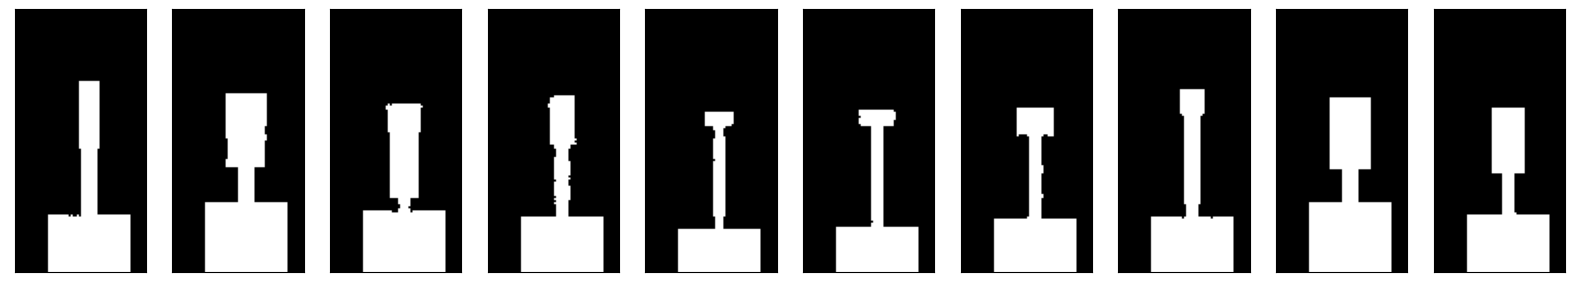

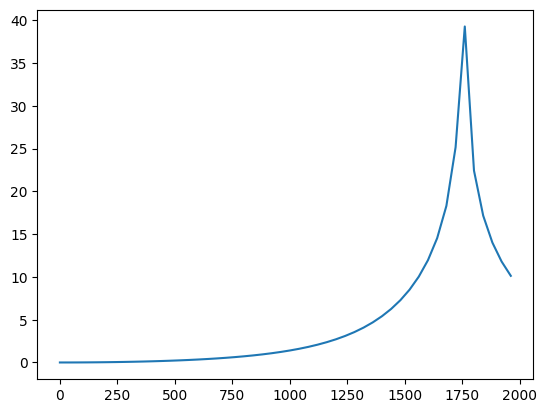

In [ ]:
# function
def latent_generate_1(model, data):
    data = np.reshape(data, (1, 50, 1))
    train_latent_value = model(data[0].reshape((1,)+ data[0].shape))

    return train_latent_value

def reparameterize_random():
    eps_list = []
    for i in range(8):
        while(True):
            eps = tf.random.normal(shape=[], mean = 0, stddev = 1)
            if (abs(eps) < 1):
                eps_list.append(eps)
                break
    return eps_list

def dist_decode(z_d):
    recon_image=decodermodel(z_d)
    a, image=cv2.threshold(np.reshape(recon_image,(128,64)),0.5,1,cv2.THRESH_BINARY)
    image=np.array(image)
    return image

# Testset에서 랜덤한 데이터 선택
k = np.random.randint(0, len(test_TL)-1)
z_fre = latent_generate_1(freencodermodel, test_TL[k])

# 이미지 : 랜덤한 latent variable 생성 / 응답 : Testset에서 랜덤하게 하나 생성 후 frequency decoder에 입력하여 차원 축소
plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    
    z_image = np.reshape(reparameterize_random(), (1, 8))
    z_d = tf.reshape(tf.concat([z_image, z_fre], axis=0), (1, 16))

    # Decoder를 통해 이미지 생성
    reco = dist_decode(z_d)
    reco_re = np.reshape(reco, (128, 64))

    # 생성된 이미지 plot
    plt.imshow(reco_re, cmap = 'gray')
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)

plt.show()

# 선택된 응답 plot
plt.plot(np.arange(1, 2000, 40), np.reshape(test_TL[k], (50)))
plt.show()

## Latent space Perturbation

1
2
3
4


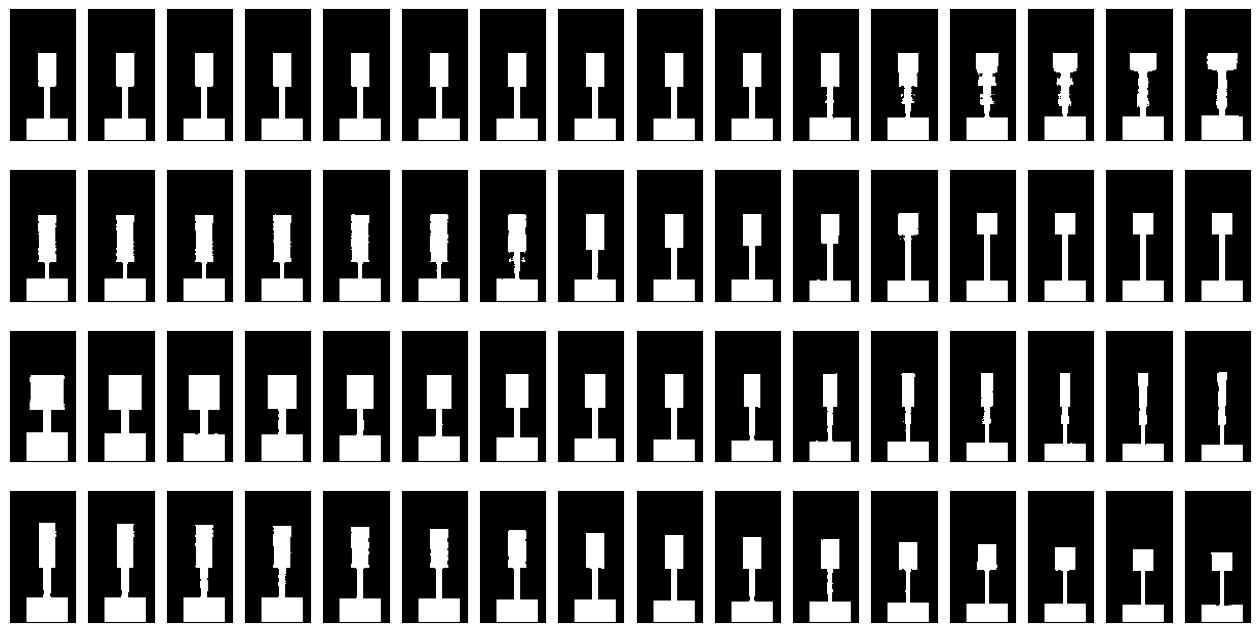

In [ ]:
perturbation_list = np.arange(-1.6, 1.6, 0.2)
plt.figure(figsize = (16, 8))
num = 0
for i in [0, 1, 3, 7]:
    for j in range(len(perturbation_list)):

        plt.subplot(4, len(perturbation_list), num*len(perturbation_list)+j+1)
        
        # i번째 latent variable을 변화시킴
        latent_list = np.zeros((8))
        latent_list[i] = perturbation_list[j]
        z_d = tf.reshape(tf.concat([np.reshape(latent_list, (1, 8)), z_fre], axis=0), (1, 16))
        
        # Decoder를 통해 이미지 생성
        reco = dist_decode(z_d)
        reco_re = np.reshape(reco, (128, 64))

        # 생성된 이미지 plot
        plt.imshow(reco_re, cmap = 'gray')
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)

    num += 1
    print(num)
plt.show()
